In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sargas import *
import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
import glob
import re

PATTERN = re.compile("(\d+.\d+)_t_(\d+.\d+)_rho.gro")

sns.set_palette("Dark2")
sns.set_style("ticks")
sns.set_context("talk")

In [2]:
def nvt(nparticles, temperature, density, rc, options=None, filename=None):
    """Run a NVT simulation with tail corrections.
    
    Parameters
    ----------
    nparticles : int
        number of particles
    temperature : float
        reduced temperature
    density : float
        reduced density
    rc : float
        cut off radius
    options : dict, optional
        specifies values for 
            nequilibration: number of equilibration cycles (5_000)
            nproduction: number production cycles (25_000)
            nsample: sample properties after this many cycles (25)
            ntrajectory: write trajectory to file after this many cycles (50)
    filename : str, optioanl
        write trajectory to this file (must end with `.gro`). 
        Default temperature_t_density_rho.gro
        
    Returns
    -------
    pd.DataFrame : data frame containing results
    """
    if options is None:
        nequilibration = 5_000
        nproduction = 25_000
        nsample = 25
        ntrajectory = 50
    else:
        nequilibration = options["nequilibration"]
        nproduction = options["nproduction"]
        nsample = options["nsample"]
        ntrajectory = options["ntrajectory"]
        
    if filename is None:
        filename = f"{temperature}_t_{density}_rho.gro"
        
    # Build the system
    lennard_jones = Potential.lennard_jones(1.0, 1.0, rc, True)
    configuration = Configuration.lattice(nparticles, density)
    system = System(configuration=configuration, potential=lennard_jones)

    # Build the propagator
    particle_displacement = MCMove.displace_particle(0.1, 0.4, temperature)
    propagator = MonteCarlo([particle_displacement], [1], temperature)

    # Build the simulation
    simulation = Simulation.monte_carlo(system, propagator)

    # Run equilibration
    #for _ in tqdm.tqdm(range(nequilibration), desc="Equilibration"):
    for _ in range(nequilibration):
        simulation.run(nparticles)
    
    # stop adjusting the maximum displacement
    simulation.deactivate_propagator_updates()
    
    # Add sampler
    properties = Sampler.properties(nparticles * nsample)
    trajectory = Sampler.trajectory(filename, nparticles * ntrajectory)
    simulation.add_sampler(properties)
    simulation.add_sampler(trajectory)
    
    # Run production
    #for _ in tqdm.tqdm(range(nproduction), desc="Production   "):
    for _ in range(nproduction):
        simulation.run(nparticles)
    
    return pd.DataFrame(properties.data)

In [3]:
def rerun_trajectory(filename, temperature, density, rc, ninsertions):
    """Read a trajectory and apply samplers.
    
    Parameters
    ----------
    filename : str
        the file name of the trajectory
    temperature : float
        reduced temperature
    density : float
        reduced density
    rc : float
        cut off radius
    ninsertions : int
        number of insertions for widom method
        
    Returns
    -------
    dict :
        dictionary containing the results
    """   
    lennard_jones = Potential.lennard_jones(1.0, 1.0, rc, True)
    
    # Build the simulation
    simulation = Simulation.rerun_trajectory(lennard_jones, filename)

    # Add sampler
    properties = Sampler.properties(1)
    widom = Sampler.widom(1, temperature, ninsertions=ninsertions)
    simulation.add_sampler(properties)
    simulation.add_sampler(widom)
    
    try:
        simulation.run(100000)
    except Exception as e:
        print(e)
    
    props = pd.DataFrame(properties.data)
    mu = pd.DataFrame(widom.data)
    return { 
        "temperature": temperature, 
        "density": density, 
        "pressure": props.pressure.mean() + density * temperature, 
        "potential_energy": props.potential_energy.mean(), 
        "chemical_potential": temperature * mu.chemical_potential.values[-1],
        "mu_ex": -temperature * np.log(mu.boltzmann_factor.values[-1] / density)
    } 

# Assignment 2: Chemical Potential and Vapor-Liquid Equilibria (VLE)

## Introduction <a id="Introduction"/>

The vapor-liquid coexistence point of a Lennard-Jones system at a
certain temperature can be found by different simulation techniques. In
this exercise we will locate the phase coexistence calculating the equation of
state of the system using simulations in the canonical ensemble (NVT),
and we will impose the conditions of phase equilibrium.

## Table of Contents <a id="toc"/>

- [Introduction](#Introduction)
- [The Chemical Potential from the Partition Function](#Chemical-Potential)
- [Widom's Particle Insertion](#Widom)
- [Compiling](#compiling-And-Testing)
- [Your Tasks](#tasks)

## The Chemical Potential from  the Partition Function <a id="Chemical-Potential"/>

[↑ back to top](#toc)

We can divide the chemical potential into two additive contributions, one for the ideal gas and one residual contribution:

\begin{align}
\mu = \mu^\text{ig} + \mu^\text{res}
\end{align}

Recall that the chemical potential is the partial derivative of the Helmholtz energy with respect to the amount of substance (or here: the number of particles). For a pure substance, we can write:

\begin{align}
\mu &= \left(\frac{\partial A}{\partial N}\right)_{T, V} \\
&= -k_BT \left(\frac{\partial \ln Q_\text{NVT}}{\partial N}\right)_{T, V} \\
\end{align}

with the quantum corrected partition function of the canonical ensemble for mono-atomic substances (omitting the internal partition function), $Q_\text{NVT}$:

\begin{align}
Q_\text{NVT} = \frac{1}{N!\Lambda^{3N}}\int e^{-\beta U(\mathbf{r}^N)} \mathrm{d}\mathbf{r}^N
\end{align}

For an ideal gas, we set the potential energy of the system to zero and then take the derivative:

\begin{align}
Q_\text{NVT}^\text{ig} &= \frac{1}{N!\Lambda^{3N}}\underbrace{\int \mathrm{d}\mathbf{r}^N}_{=V^N} \\
\mu^\text{ig} &= -k_BT \frac{\partial}{\partial N} \left( N\ln V - \ln N! - N\ln\Lambda^3 \right) \\
&= k_BT \ln \left[\rho\Lambda^3\right]
\end{align}



## Widom's Particle Insertion <a id="Widom"/>

[↑ back to top](#toc)

The residual contribution to the chemical potential requires integration over all possible microstates of the system for the given control variables $N, V$ and $T$. However, for a molecular system, the smallest possible change in the amount of substance ($N$) is removing or adding a single molecule or particle. We can approximate the chemical potential by adding a (ghost) particle to the system:

\begin{align}
\mu &= \frac{A(N+\Delta N, V, T) - A(N, V, T)}{\Delta N} \\
&\underbrace{=}_{\Delta N = 1} A(N+1, V, T) - A(N, V, T) \\
&= -k_B T \ln \frac{Q_\text{N+1VT}}{Q_\text{NVT}} \\
&= \mu^\text{ig} - k_BT \ln \langle e^{-\beta \Delta^+ U(\mathbf{r}^N, \mathbf{r}^+)}  \rangle
\end{align}

with $\Delta^+ U(\mathbf{r}^N, \mathbf{r}^+)$ being the energy of the ghost particle (at position $\mathbf{r}^+$) with all other particles (at positions $\mathbf{r}^N$) in the system.

The tail correction is approximately twice the per-particle energy tail correction. 

\begin{equation}
  \beta\mu^\text{tail} \approx 2 u^\text{tail}(\rho)
\end{equation}

For very small numbers of particles, this approximation is not suitable.

## Compiling <a id="compiling-And-Testing"/>

[↑ back to top](#toc)

**There are no tests in this assignment.**

To **compile** the code (*which does not build the python module*), use 

```
RUSTFLAGS="-C target-cpu=native" cargo build --release
```

To build the **Python module**, type

```
RUSTFLAGS="-C target-cpu=native" maturin develop --release
```

If the last step fails stating that "the resource is currently in use" (or something similar) make sure to **stop the Jupyter kernel** and try running the command again.

---
## Your Tasks <a id="tasks"/>

[↑ back to top](#toc)

---
### 1. Implement the Widom Algorithm

**Implement the test particle insertion algorithm in `src/sampler.rs` in the function `particle_insertion`.**

The function has to do the following:

1. It takes the `System`, the number of test particle insertions, `ninsertions`, and the inverse temperature, `beta`, as input.
2. For each of `ninsertions`:
    - generate a random position in the simulation box
    - compute the energy of the test particle with all particles in the system (use the `system.particle_energy` function which is defined in `src/system.rs`)
    - compute the Boltzmann factor needed for the chemical potential
3. Return the sum of Boltzmann factors (a single floating point number)

The actual computation of the chemical potential is already implemented for you:

```rust
impl Sampler for WidomSampler {
    // Some other functions omittedcurrent_boltzmann_factor_mean
    
    fn sample(&mut self, system: &System) {
        let sum_boltzmann_factor = particle_insertion(system, self.ninsertions, self.beta);
        let density = system.density();
        let nparticles = system.configuration.nparticles;
        let u_tail = system.potential.energy_tail(density, nparticles) / nparticles as f64;
        // current_boltzmann_factor_mean is the last value that was recorded for <exp(-beta deltaU)>
        let new_boltzmann_factor_mean =
            if let Some(current_boltzmann_factor_mean) = self.boltzmann_factor.last() {
                (current_boltzmann_factor_mean * self.inserted as f64 + sum_boltzmann_factor)
                    / (self.inserted as f64 + self.ninsertions as f64)
            } else {
                sum_boltzmann_factor / self.ninsertions as f64
            };
        self.chemical_potential
            .push(density.ln() + 2.0 * u_tail - new_boltzmann_factor_mean.ln());
        self.boltzmann_factor.push(new_boltzmann_factor_mean);
        self.inserted += self.ninsertions as u32;
    }
}
```

The computation of the chemical potential is done with a `Sampler`.
For a specified frequency and number of insertions, the `sample` function is called.

- `sum_boltzmann_factor` is the result of the `particle_insertion` function you implemented,
- `self.inserted` is the number of particle insertions before the current sample is taken,
- `self.ninsertion` is the number of particles that are inserted each time the `sample` function is called,
- `current_boltzmann_factor_mean` is the mean value of the Boltzmann factor before the current sample is taken

**Explain in your own words what the `sample` of the `WidomSampler` function does.**

---
### 2. Calculate the Chemical Potential

- **For the given simulation parameters, conduct two simulations: one for $\rho^*=0.1$ and one for $\rho^*=0.8$. Use the `nvt` function that is defined at the start of this notebook.**
- **Use the code in the cell below to read the trajectory that was generated by your simulations. In the "rerun", conduct particle insertions. Experiment with the number of insertions.**
- **Store the results for each simulation in a csv file.**
- **Plot the chemical potential over the simulation time for both densities. Why is it more difficult to calculate the chemical potential at high densities?**

#### Simulation Parameters

|property| value|
|-|-|
|$T^*$|2.0|
|$N$|108|
|$r_c$|2.5|
|tail correction| yes|

In [ ]:
# run two simulations using the `nvt` function
rc = 2.5
filename = "your-filename.gro"
temperature =  
density = 

results = nvt()

In [ ]:
ninsertions = 

# Set up a simulation that re-runs the trajectory
lennard_jones = Potential.lennard_jones(1.0, 1.0, rc, True)
simulation = Simulation.rerun_trajectory(lennard_jones, filename)

# Add widom sampler
properties = Sampler.properties(1)
widom = Sampler.widom(1, temperature, ninsertions=ninsertions)
simulation.add_sampler(properties)
simulation.add_sampler(widom)

In [ ]:
# run the "simulation"
simulation.run(100000)

In [ ]:
props = pd.DataFrame(properties.data)
mu = pd.DataFrame(widom.data)

In [ ]:
# your mu-vs-mc-cycles plot

---
### 3. VLE of the Lennard-Jones Fluid

- **Calculate the vapor-liquid equilibrium using a series of NVT simulations going from a low to a high density at given temperature.**

To do that:

1. **Conduct simulations using the next two cells.**
2. **Read the trajectories, and perform Widom insertion in a re-run. For that, we use the `rerun_trajectory` function defined in the top of the notebook.**
3. **Optional: In the `rerun_trajectory` function, currently there are no statistical uncertainties computed. Implement uncertainties for the pressure and add them to the results**
4. **Generate a plot that enables you to estimate the phase equilibrium. What is the chemical potential, pressure and the liquid and vapor density at phase equilibrium?**
5. **In the definition of the chemical potential of an ideal gas appears the de Broglie wavelength, $\Lambda$. We omitted $\Lambda$ in our implementation - why do we still get the correct VLE?**

#### Simulation Parameters

|property| value|
|-|-|
|$T^*$|0.8|
|$N$|500|
|$r_c$|3.0|
|tail correction| yes|

In [4]:
temperature = 0.8
nparticles = 256
rc = 3.0

# to use the default options of `rerun_trajectory` you can remove the `options` from the `inputs` below.
options = { 
    "nequilibration": 1000,
    "nproduction": 5000,
    "nsample": 20,
    "ntrajectory": 20,
}
densities = [0.00125, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8]
inputs = [(nparticles, temperature, density, rc, options) for density in densities]

In [5]:
# run all simulations in parallel
with Pool() as pool:
    results = pool.starmap(nvt, inputs)

In [12]:
# this generates the input arguments for all reruns.
# it parses the temperature and density from the file names
widom_inputs = []
ninsertions = 2000
for filename in glob.glob("*rho.gro"):
    t, rho = PATTERN.search(filename).groups()
    t = float(t)
    rho = float(rho)
    widom_inputs.append((filename, t, rho, rc, ninsertions))

In [13]:
# re-run all simulations in parallel
with Pool() as pool:
    results = pool.starmap(rerun_trajectory, widom_inputs)

End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.End of trajectory reached.

End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.
End of trajectory reached.


## Results

In [14]:
results = pd.DataFrame(results)
results.sort_values(by="density", inplace=True)
results

,temperature,density,pressure,potential_energy,chemical_potential,mu_ex
14,0.8,0.00125,0.000994,-2.810939,-5.363280,-5.362660
13,0.8,0.00250,0.001967,-5.007084,-4.823907,-4.822665
15,0.8,0.00500,0.003837,-14.579519,-4.300509,-4.298028
17,0.8,0.00750,0.005618,-23.245304,-4.007385,-4.003664
16,0.8,0.01000,0.007377,-25.768327,-3.808325,-3.803359
0,0.8,0.02000,0.013609,-56.656426,-3.378986,-3.369066
1,0.8,0.03000,0.018216,-94.521766,-3.188056,-3.173171
2,0.8,0.04000,0.021739,-124.410087,-3.088282,-3.068428
3,0.8,0.05000,0.024082,-155.974240,-3.047354,-3.022540
4,0.8,0.07500,0.023069,-247.069094,-3.057588,-3.020368


## Generate Plots

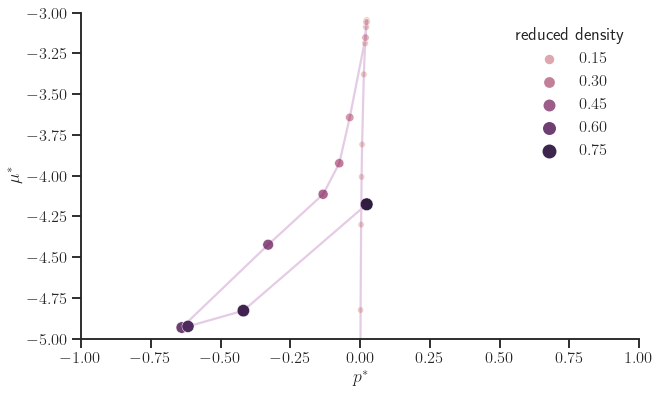

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=results, y="chemical_potential", x="pressure", ax=ax, color="purple", alpha=0.2, sort=False);
sns.scatterplot(data=results, y="chemical_potential", x="pressure", hue="density", size="density", ax=ax);
ax.set_xlim(-1, 1)
ax.set_ylim(-5, -3)
ax.set_ylabel("$\mu^{*}$")
ax.set_xlabel("$p^*$")
ax.legend(frameon=False, title="reduced density")
sns.despine()

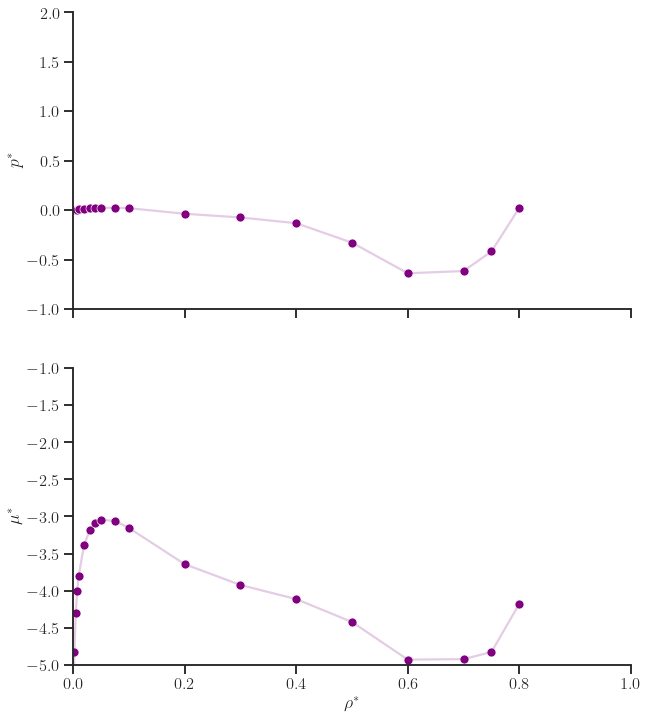

In [16]:
ig, ax = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
sns.lineplot(data=results, y="pressure", x="density", ax=ax[0], color="purple", alpha=0.2, sort=False);
sns.scatterplot(data=results, y="pressure", x="density", color="purple", ax=ax[0]);

ax[0].set_ylabel("$p^{*}$")
ax[0].set_xlabel(r"$\rho^*$")
ax[0].set_ylim(-1, 2)

sns.lineplot(data=results, y="chemical_potential", x="density", color="purple", alpha=0.2, sort=False, ax=ax[1]);
sns.scatterplot(data=results, y="chemical_potential", x="density", color="purple", ax=ax[1]);
ax[1].set_xlim(0, 1)
ax[1].set_ylim(-5, -1)
ax[1].set_ylabel(r"$\mu^{*}$")
ax[1].set_xlabel(r"$\rho^*$")
sns.despine()